# Part 3: Hands-On Project

**_Corey White and Caitlin Haedrich_**

_FOSS4G-NA 2025_

1. Write the core functionality of your addon in the main script file
   (e.g., `r.simwe.scenario.py`).
2. Use GRASS libraries and tools to interact with GRASS data and perform
   operations.
3. Follow best practices for coding style and documentation.
4. Implement error handling and input validation.
5. Write unit tests to ensure the addon works as expected.
6. Write documentation for the addon, including usage instructions and examples.

In [3]:
%%bash
# cookiecutter https://github.com/cwhite911/grass-addon-cookiecutter --checkout grass-tools
# When using uv as a package manager, uncomment the following line:
# uv run cookiecutter https://github.com/cwhite911/grass-addon-cookiecutter --checkout grass-tools

- You've downloaded /home/coreywhite/.cookiecutters/grass-addon-cookiecutter before. Is it okay to delete and re-download it? [y/n] (y): y
  - [1/4] tool (Addon name): r.simwe.scenario           
  - [2/4] author_name (Your name (or your organization/company/team)): Corey T. White
  - [3/4] email (Your email): smortopahri@gmail.com
  - [4/4] description (A short description of the project.): Run overland flow scenarios with the SIMWE model.

Let migrate our existing script into this new addon structure.

```python
#!/usr/bin/env python3

import subprocess
import sys


def run_simwe(elevation, rainfall_rate=10, depth_output="depth", tools=None):
    tools.r_slope_aspect(elevation=elevation, dx="dx", dy="dy")
    tools.r_sim_water(
        elevation=elevation,
        dx="dx",
        dy="dy",
        rain_value=rainfall_rate,
        depth=depth_output,
    )


def main():
    # Append GRASS to the python system path
    sys.path.append(
        subprocess.check_output(["grass", "--config", "python_path"], text=True).strip()
    )

    import grass.script as gs
    from grass.tools import Tools

    # Initialize the GRASS session
    with gs.setup.init("/root/nc_basic_spm_grass7") as session:
        tools = Tools(session=session)
        tools.g_region(
            raster="elevation", res=40
        )  # notice res downsampling so this script runs quickly!
        run_simwe(elevation="elevation", rainfall_rate=60, tools=tools)


if __name__ == "__main__":
    main()

```

## Header details and options

The header should be good unless you want to add additional details such as adding another co-author.
However, we need to update our keywords and standard options.

These include:

* Input: elevation raster
* Input: Rainfall rain (mm/hr)
* Output: simulation raster

Try to add keywords and update the standard options to your `r.simwe.scenario/r.simwe.scenario.py` file.

<details>
    <summary>👉 <b>click to see solution</b></summary>

```python
#!/usr/bin/env python

##############################################################################
# MODULE:    r.simwe.scenario
#
# AUTHOR(S): Corey T. White <smortopahri@gmail.com>
#            Caitlin Haedric
#
# PURPOSE:   Run overland flow scenarios with the SIMWE model.
#
# COPYRIGHT: (C) 2025 by Corey T. White and the GRASS Development Team
#
#            This program is free software under the GNU General Public
#            License (>=v2). Read the file COPYING that comes with GRASS
#            for details.
##############################################################################

"""Run overland flow scenarios with the SIMWE model."""

# %module
# % description: Run overland flow scenarios with the SIMWE model.
# % keyword: raster
# % keyword: hydrology
# % keyword: water
# %end
# %option G_OPT_R_ELEV
# %required: yes
# %end
# %option G_OPT_R_OUTPUT
# % description: Name for output depth raster [m]
# % required: yes
# %end
# %option
# % key: rainfall_rate
# % type: double
# % description: Rainfall rate (mm/hr)
# % answer: 10
# %end
# %option
# % key: min_depth
# % type: double
# % description: Minimum depth to retain in output raster (m) if -d flag is set
# % answer: 0.01
# %end
# %option G_OPT_M_NPROCS
# %end
# %option G_OPT_M_SEED
# %end
# %flag
# % key: d
# % description: Limit output to depths above 0.01 m
# %end
```
</details>

## Update the main script

We now need to update our `main` function and add our `run_simwe` function from our script.

Update your main script to use the options you set in the above step, and add your modify the `run_simwe` function to work with the options in the `r.simwe.scenario/r.simwe.scenario.py` file.

<details>
    <summary>👉 <b>click to see solution</b></summary>

```python


import sys
import atexit
from gettext import gettext as _
import grass.script as gs
from grass.tools import Tools


def clean(names: list, tools=None):
    tools.g_remove(type="raster", name=names, flags="f", superquiet=True)


def run_simwe(elevation, dx, dy, rainfall_rate, depth_output, procs, seed, tools=None):
    """Run SIMWE overland flow model."""
    tools.r_slope_aspect(elevation=elevation, dx=dx, dy=dy)
    tools.r_sim_water(
        elevation=elevation,
        dx=dx,
        dy=dy,
        rain_value=rainfall_rate,
        depth=depth_output,
        random_seed=seed,
        nprocs=procs,
    )


def limit_depths(output_raster, depth_raster, min_depth, tools=None):
    """Limit depth raster to values above a minimum depth."""
    tools.r.mapcalc(
        expression=f"{output_raster} = if({depth_raster} >= {min_depth}, {depth_raster}, null())",
        overwrite=True,
    )

    # Set color table for output raster back to that of the original depth raster
    tools.r.colors(map=output_raster, raster=depth_raster)


def main():
    # initalize tools
    tools = Tools(overwrite=True)

    # get input options
    options, flags = gs.parser()
    elevation = options["elevation"]
    output_raster = options["output"]
    rainfall_rate = float(options["rainfall_rate"])
    min_depth = float(options["min_depth"])
    procs = options["nprocs"]
    seed = options["seed"]

    # crete a temporary raster that will be removed upon exit
    temporary_raster_dx = gs.append_node_pid("dx")
    temporary_raster_dy = gs.append_node_pid("dy")
    output_depth_raster = gs.append_node_pid("depth") if flags["d"] else output_raster
    temp_files = [temporary_raster_dx, temporary_raster_dy]
    atexit.register(clean, temp_files, tools=tools)

    gs.debug(
        _("Running r.simwe.scenario with %s processes and seed %s") % (procs, seed)
    )
    gs.message(_("Running scenario..."))
    # run analysis
    run_simwe(
        elevation=elevation,
        dx=temporary_raster_dx,
        dy=temporary_raster_dy,
        rainfall_rate=rainfall_rate,
        depth_output=output_depth_raster,
        procs=procs,
        seed=seed,
        tools=tools,
    )

    # flags
    if flags["d"]:
        gs.message(_("Filtering depth..."))
        limit_depths(output_raster, output_depth_raster, min_depth, tools=tools)

    # save history into the output raster
    gs.raster_history(output_raster, overwrite=True)
```
</details>

## Final script

You should now have a working addon.
 
<details>
    <summary>👉 <b>click to see solution</b></summary>

```python
#!/usr/bin/env python

##############################################################################
# MODULE:    r.simwe.scenario
#
# AUTHOR(S): Corey T. White <smortopahri@gmail.com>
#
# PURPOSE:   Run overland flow scenarios with the SIMWE model.
#
# COPYRIGHT: (C) 2025 by Corey T. White and the GRASS Development Team
#
#            This program is free software under the GNU General Public
#            License (>=v2). Read the file COPYING that comes with GRASS
#            for details.
##############################################################################

"""Run overland flow scenarios with the SIMWE model."""

# %module
# % description: Run overland flow scenarios with the SIMWE model.
# % keyword: raster
# % keyword: hydrology
# % keyword: water
# %end
# %option G_OPT_R_ELEV
# %required: yes
# %end
# %option G_OPT_R_OUTPUT
# % description: Name for output depth raster [m]
# % required: yes
# %end
# %option
# % key: rainfall_rate
# % type: double
# % description: Rainfall rate (mm/hr)
# % answer: 10
# %end
# %option
# % key: min_depth
# % type: double
# % description: Minimum depth to retain in output raster (m) if -d flag is set
# % answer: 0.01
# %end
# %option G_OPT_M_NPROCS
# %end
# %option G_OPT_M_SEED
# %end
# %flag
# % key: d
# % description: Limit output to depths above 0.01 m
# %end

import sys
import atexit
from gettext import gettext as _
import grass.script as gs
from grass.tools import Tools


def clean(names: list, tools=None):
    tools.g_remove(type="raster", name=names, flags="f", superquiet=True)


def run_simwe(elevation, dx, dy, rainfall_rate, depth_output, procs, seed, tools=None):
    """Run SIMWE overland flow model."""
    tools.r_slope_aspect(elevation=elevation, dx=dx, dy=dy)
    tools.r_sim_water(
        elevation=elevation,
        dx=dx,
        dy=dy,
        rain_value=rainfall_rate,
        depth=depth_output,
        random_seed=seed,
        nprocs=procs,
    )


def limit_depths(output_raster, depth_raster, min_depth, tools=None):
    """Limit depth raster to values above a minimum depth."""
    tools.r.mapcalc(
        expression=f"{output_raster} = if({depth_raster} >= {min_depth}, {depth_raster}, null())",
        overwrite=True,
    )

    # Set color table for output raster back to that of the original depth raster
    tools.r.colors(map=output_raster, raster=depth_raster)


def main():
    # initalize tools
    tools = Tools(overwrite=True)

    # get input options
    options, flags = gs.parser()
    elevation = options["elevation"]
    output_raster = options["output"]
    rainfall_rate = float(options["rainfall_rate"])
    min_depth = float(options["min_depth"])
    procs = options["nprocs"]
    seed = options["seed"]

    # crete a temporary raster that will be removed upon exit
    temporary_raster_dx = gs.append_node_pid("dx")
    temporary_raster_dy = gs.append_node_pid("dy")
    output_depth_raster = gs.append_node_pid("depth") if flags["d"] else output_raster
    temp_files = [temporary_raster_dx, temporary_raster_dy]
    atexit.register(clean, temp_files, tools=tools)

    gs.debug(
        _("Running r.simwe.scenario with %s processes and seed %s") % (procs, seed)
    )
    gs.message(_("Running scenario..."))
    # run analysis
    run_simwe(
        elevation=elevation,
        dx=temporary_raster_dx,
        dy=temporary_raster_dy,
        rainfall_rate=rainfall_rate,
        depth_output=output_depth_raster,
        procs=procs,
        seed=seed,
        tools=tools,
    )

    # flags
    if flags["d"]:
        gs.message(_("Filtering depth..."))
        limit_depths(output_raster, output_depth_raster, min_depth, tools=tools)

    # save history into the output raster
    gs.raster_history(output_raster, overwrite=True)


if __name__ == "__main__":
    sys.exit(main())
```

</details>

## Install your addon to see if it works

In [12]:
import subprocess
import sys

# Ask GRASS where its Python packages are.
sys.path.append(
    subprocess.check_output(["grass", "--config", "python_path"], text=True).strip()
)

# Import GRASS packages
import grass.script as gs
import grass.jupyter as gj
from grass.tools import Tools

# Start GRASS Session
session = gj.init("/root/nc_basic_spm_grass7/user1")
tools = Tools(session=session)
tools.g_extension(extension="r.simwe.scenario", url="./r.simwe.scenario")


In [19]:
help(tools.r_simwe_scenario.__module__)

Help on module grass.tools.support in grass.tools:

NAME
    grass.tools.support

DESCRIPTION
    The module provides support functionality for calling GRASS tools (modules)
    as Python functions.

    Do not use this module directly unless you are developing GRASS or its wrappers.
    In that case, be prepared to update your code if this module changes. This module may
    change between releases.

CLASSES
    builtins.object
        ParameterConverter
        ToolFunctionResolver
        ToolResult

    class ParameterConverter(builtins.object)
     |  Converts parameter values to strings and facilitates flow of the data.
     |
     |  Methods defined here:
     |
     |  __init__(self)
     |      Initialize self.  See help(type(self)) for accurate signature.
     |
     |  process_parameter_list(self, command)
     |      Converts or at least processes parameters passed as list of strings
     |
     |  process_parameters(self, kwargs)
     |      Converts high level parameter v

In [8]:
# This part is needed becuase we are working inside a Jupyter notebook
%load_ext autoreload
%autoreload 2
# Re-Import GRASS packages
import grass.script as gs
import grass.jupyter as gj
from grass.tools import Tools

r_simwe_scenario_input = "elevation"
r_simwe_scenario_output = "depth"

tools.g_region(raster=r_simwe_scenario_input, s="s+5500", n="n-1500", w="w+3500", e="e-4000", flags="p", save="r_sim_region")
with gs.RegionManager(region="r_sim_region"):
    tools.r_simwe_scenario(elevation=r_simwe_scenario_input, output=r_simwe_scenario_output)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


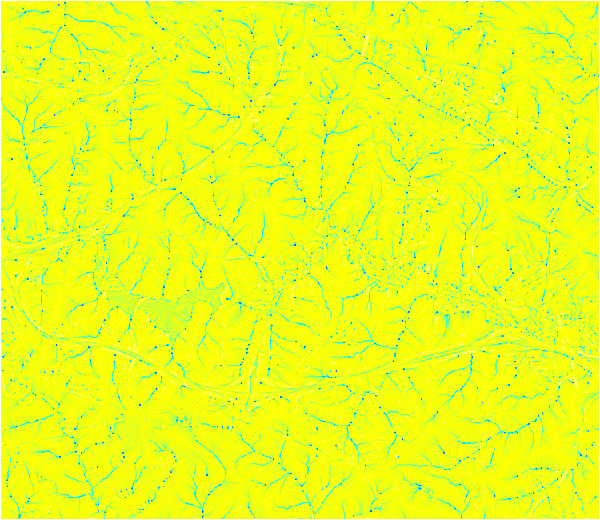

In [9]:
r_simwe_scenario_map = gj.Map(saved_region="r_sim_region")
r_simwe_scenario_map.d_rast(map=r_simwe_scenario_output)
r_simwe_scenario_map.show()

Now let's try setting an additional option.

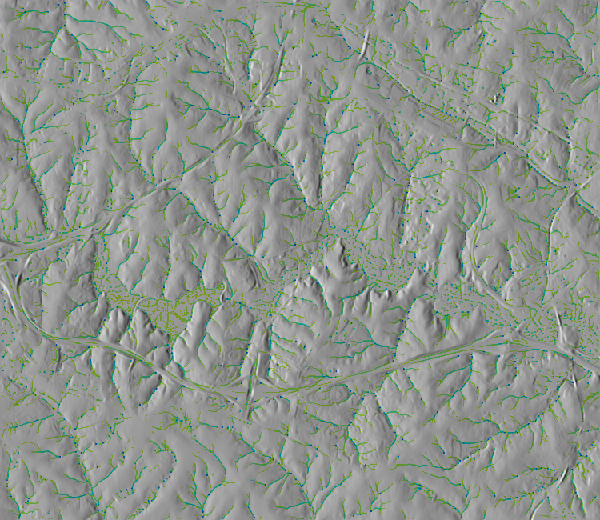

In [22]:
r_simwe_scenario_output_2 = "depth_flag"
with gs.RegionManager(region="r_sim_region"):
    tools.r_simwe_scenario(elevation=r_simwe_scenario_input, output=r_simwe_scenario_output_2, flags="d")
    r_simwe_scenario_map = gj.Map(saved_region="r_sim_region", filename="./r.simwe.scenario/r_simwe_scenario.png")
    r_simwe_scenario_map.d_shade(shade="elevation_shade", color=r_simwe_scenario_output_2)
    r_simwe_scenario_map.show()